In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Data preprocessing
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

In [11]:
if 'SignupDate' in customers.columns:
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'], errors='coerce')
else:
    customers['SignupDate'] = pd.NaT

In [12]:
# Feature engineering
customer_agg = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionDate': ['min', 'max']
}).reset_index()

In [13]:
customer_agg.columns = ['CustomerID', 'TransactionCount', 'TotalSpend', 'TotalQuantity', 'FirstPurchaseDate', 'LastPurchaseDate']


In [14]:
# Calculate customer tenure
customer_agg['CustomerTenure'] = (customer_agg['LastPurchaseDate'] - customer_agg['FirstPurchaseDate']).dt.days

In [15]:
customer_agg = customer_agg.merge(customers[['CustomerID', 'SignupDate']], on='CustomerID', how='left')
customer_agg['SignupTenure'] = (pd.Timestamp.today() - customer_agg['SignupDate']).dt.days.fillna(0).astype(int)

In [16]:
df = pd.merge(customers, customer_agg, on='CustomerID')

In [17]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['Region'], drop_first=True)

In [18]:
# Feature selection
features = ['TransactionCount', 'TotalSpend', 'TotalQuantity', 'CustomerTenure', 'SignupTenure']
X = df[features]

In [19]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Determine optimal number of clusters using Elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

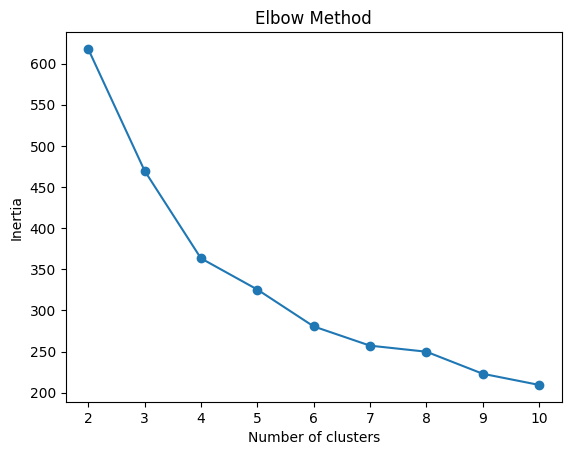

In [21]:
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [22]:
# Clustering using optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [23]:
# Evaluate clustering
db_index = davies_bouldin_score(X_scaled, df['Cluster'])
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])

In [24]:
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

Davies-Bouldin Index: 1.1057676220191057
Silhouette Score: 0.2978627659907817


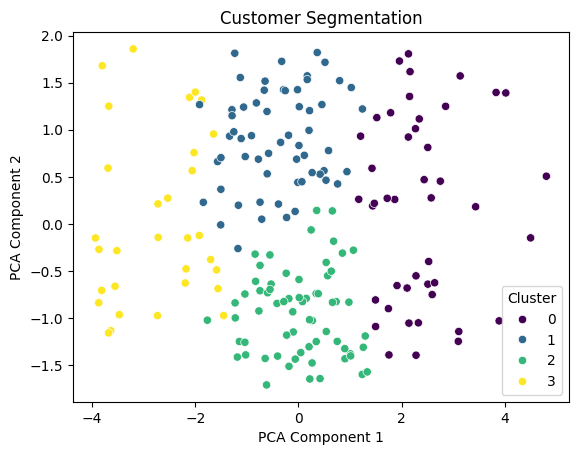

In [25]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis')
plt.title('Customer Segmentation')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [26]:
# Save results
df.to_csv('Customer_Segmentation_Results.csv', index=False)